In [61]:
from itertools import cycle
from glob import glob
from typing import Union, Tuple, List
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Arrow, Rectangle, Polygon, Circle, PathPatch
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.collections import PatchCollection, PolyCollection
import matplotlib.colors as mcolors

import numpy as np
from numpy.typing import ArrayLike, NDArray
from pandas.core.window import rolling
from pycocotools import coco
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.losses import Loss
from tensorflow.keras.utils import load_img
import pprint as pp

from src.utils.box_cutter import BoundingBox_Processor
from src.utils.classes import CategoricalDataGen
from src.utils.data_worker import LabelWorker
from src.utils.funcs import *
from src.utils.disviz import intersection_shapes, display_label

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2
%aimport src.utils.funcs
%aimport src.utils.box_cutter
%aimport src.utils.classes
%aimport src.utils.data_worker

In [6]:
pp.PrettyPrinter(indent=4)

In [7]:
color = cycle(["orange", "crimson", "tomato",
               "springgreen", "aquamarine", 
               "fuchsia", "deepskyblue", 
               "mediumorchid", "gold"])
images = sorted(glob("./data/images/train/*"))

In [11]:
data = init_COCO("./data/", ['train', 'val', 'test'])
box_cutter = BoundingBox_Processor()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Found 269 train images
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Found 55 val images
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Found 60 test images


In [12]:
labeler = LabelWorker(data_name='train',
                      coco_obj=data,
                      image_path='./data/images/',
                      input_size=(1440, 1920),
                      target_size=(384, 512))

In [14]:
num_anchors = 9
labels = labeler.label_list()[:16]
anchors = stack_anchors(generate_anchors(labels, boxes_per_cell=num_anchors, random_state=42))
label_corners = get_corners(labels)
anchor_corners = get_corners(anchors)
label_edges = get_edges(label_corners)
anchor_edges = get_edges(anchor_corners)
print(f"labels shape: {labels.shape}")
print(f"label_corners shape: {label_corners.shape}")
print(f"label_edges shape: {label_edges.shape}")
print(f"anchors shape: {anchors.shape}")
print(f"anchor_corners shape: {anchor_corners.shape}")
print(f"anchor_edges shape: {anchor_edges.shape}")

labels shape: (16, 18, 19)
label_corners shape: (16, 18, 4, 2)
label_edges shape: (16, 18, 4, 2, 2)
anchors shape: (16, 972, 5)
anchor_corners shape: (16, 972, 4, 2)
anchor_edges shape: (16, 972, 4, 2, 2)


In [ ]:
anchor_edges[0, an::108].shape

In [ ]:
old_corners = box_cutter.get_corners(labels)[0]
old_anchors = box_cutter.get_corners(anchors)[0]
print(f"old_corners: {old_corners.shape}")
print(f"old_anchros: {old_anchors.shape}")
old_intersections = box_cutter.rolling_intersection(old_corners, old_anchors)[0]
old_intersections.shape

In [22]:
x_points = construct_intersection_vertices(labels, anchors, num_pumps=num_anchors)
print(f"x_points: {x_points.shape}")

x_points: (16, 18, 972, 24, 2)


In [23]:
intersection = intersection_area(x_points)
union = union_area(label_corners, anchor_corners, intersection, num_pumps=num_anchors)
print(f"areas: {intersection.shape}, {intersection.dtype}")
print(f"areas:\n{intersection[0, bb, an::108]}")
print(f"union: {union.shape}, {union.dtype}")
print(f"union:\n{union[0, bb, an::108]}")

areas: (16, 18, 972), <dtype: 'float32'>
areas:
[ 830.51685  791.1969  1019.1475  1502.7808 ]
union: (16, 18, 972), <dtype: 'float32'>
union:
[ 7877.1016  9424.127  12553.503   9077.145 ]


In [58]:
giou = calculate_giou(label_corners, anchor_corners, union, intersection)
print(f"giou: {giou[img, bb, an::108]}")

all_points: (16, 18, 972, 8, 2), <dtype: 'float32'>
all_points: [[ 74.69809   198.81319  ]
 [ 98.1917    217.34683  ]
 [257.22992    15.746826 ]
 [233.73631    -2.7868118]
 [175.10669   239.79678  ]
 [187.81264   211.59341  ]
 [ 38.22664   144.20322  ]
 [ 25.52069   172.40659  ]]
axes: (0, 1, 2, 3, 4)
gMax: (16, 18, 972, 2), <dtype: 'float32'>
gMin: (16, 18, 972, 2), <dtype: 'float32'>
gMax: [257.22992 239.79678]
gMin: [25.52069   -2.7868118]
C: (16, 18, 972), <dtype: 'float32'>
C: 56208.85546875
giou: [0.08073419 0.08498327 0.20920373 0.10530737 0.08384828 0.08110465
 0.16544639]


In [59]:
iou = intersection / union
triangles, int_edges = intersection_shapes(labels, anchors, num_pumps=num_anchors)
print(f"IoU: {iou.shape}, {iou.dtype}")
print(f"IoU:\n{iou[0, bb, an::108]}")
print(f"triangles: {triangles.shape}, {triangles.dtype}")
print(f"int_edges: {int_edges.shape}, {int_edges.dtype}")

IoU: (16, 18, 972), <dtype: 'float32'>
IoU:
[0.0808189  0.08507889 0.20931764 0.10543432 0.08395439 0.08118431
 0.16555655]
triangles: (16, 18, 972, 8, 3, 2), <dtype: 'float32'>
int_edges: (16, 18, 972, 8, 2, 2), <dtype: 'float32'>


In [122]:
# Select a set of bounding boxes and anchors to display
img, bb, an = (0, 5, 9 * 2 + 4 + 108*2)

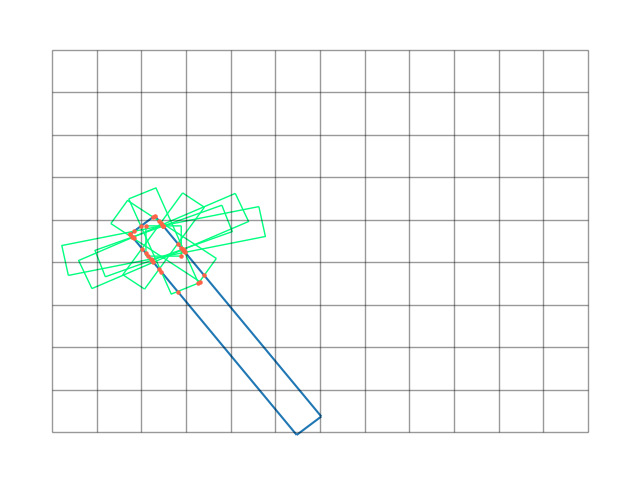

In [105]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set(
        ylim=[-40, 384+40],
        xlim=[-40, 512+40],
        xticks=list(range(0, 512,int(np.ceil(512/12)))),
        yticks=list(range(0, 384, int(np.ceil(384/9)))),
        )
lines = []
verts = []
xpoints = []
ypoints = []
an_num = x_points[img, bb, an::108].shape[0]
for x in range(an_num):
#     print(x, an + x * 108)
    for i in range(x_points.shape[-2]):
        point = x_points[img, bb, an + x * 108, i]
        if point[0] == 0:
            continue
        xpoints.append(point[0])
        ypoints.append(point[1])
for i in range(0, 13, 1):
    line = i * 512/12
    lines.append([(line, 0), (line, 384)])
for i in range(0, 10, 1):
    line = i * 384/9
    lines.append([(0, line), (512, line)])
grid_lines = mpl.collections.LineCollection(lines, colors='black', lw=1, alpha=.4, zorder=200)
ax.add_collection(grid_lines)
ax.add_collection(mpl.collections.LineCollection(label_edges[img, bb]))
ax.add_collection(mpl.collections.LineCollection(anchor_edges[img, an::108].numpy().reshape(14,4,2), lw=1, color="springgreen"))
ax.scatter(xpoints, ypoints, color="tomato", marker="o", s=5, lw=1, zorder=250)
ax.axis('off')
plt.show()

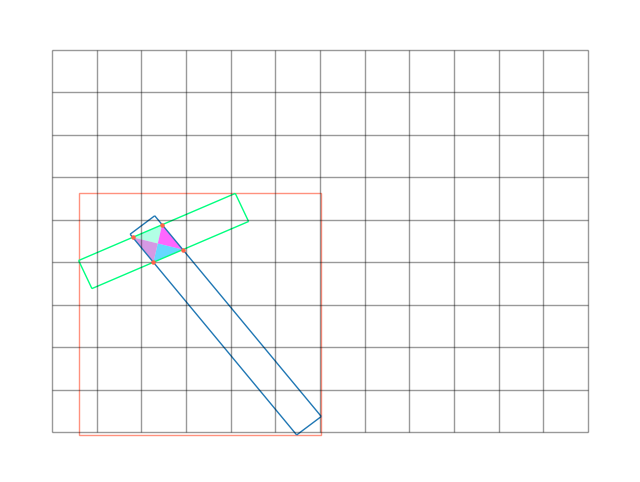

In [123]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set(
        ylim=[-40, 384+40],
        xlim=[-40, 512+40],
        xticks=list(range(0, 512,int(np.ceil(512/12)))),
        yticks=list(range(0, 384, int(np.ceil(384/9)))),
        )
lines = []
edges = []
points = []
triangles_list = []
tri_colors = []
faces = []
xpoints = []
ypoints = []
for i in range(triangles.shape[-3]):
    triangle = triangles[img, bb, an, i] 
    if triangle[0, 0] == 0:
        continue
    tri_colors.append(next(color))
    triangles_list.append(Polygon(triangle))
for i in range(x_points.shape[-2]):
    point = x_points[img, bb, an, i]
    if point[0] == 0:
        continue
    xpoints.append(point[0])
    ypoints.append(point[1])
    # points.append(Circle(point, radius=5, fill=False))
for i in range(0, 13, 1):
    line = i * 512/12
    lines.append([(line, 0), (line, 384)])
for i in range(0, 10, 1):
    line = i * 384/9
    lines.append([(0, line), (512, line)])
grid_lines = mpl.collections.LineCollection(lines, colors='black', lw=1, alpha=.4, zorder=200)
ax.add_collection(grid_lines)
ax.add_collection(mpl.collections.LineCollection(label_edges[img, bb], lw=1))
ax.add_collection(mpl.collections.LineCollection(anchor_edges[img, an].numpy(), lw=1, color="springgreen"))
# ax.add_patch(PathPatch(paths, edgecolor="tab:purple", facecolor="tab:purple", alpha=.4, zorder=200))
ax.add_collection(PatchCollection(triangles_list, facecolor=tri_colors, edgecolor=None, alpha=.6))
ax.add_patch(Rectangle(xy[img, bb, an], wh[img, bb, an, 0], wh[img, bb, an, 1], fill=None, edgecolor="tomato", alpha=.7))
ax.scatter(xpoints, ypoints, color="tomato", marker="o", s=5, lw=1, zorder=250)
ax.axis('off')
plt.show()

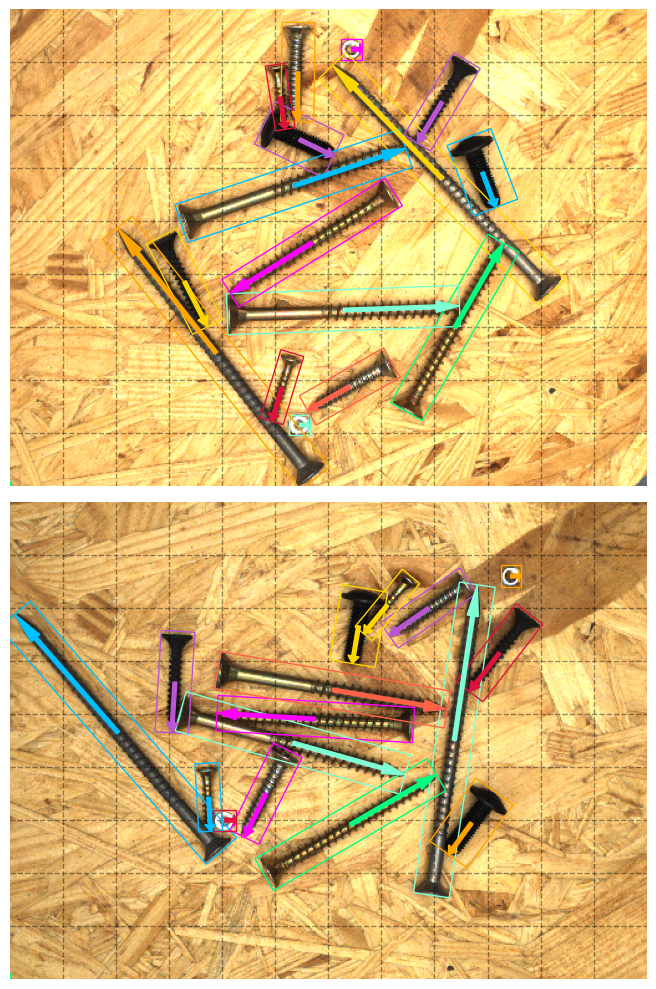

In [118]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10))
# axs = np.concatenate([ax1, ax2], axis=-1)
for img, ax in enumerate(axs):
    lines = []
    for i in range(1, 12, 1):
        line = i * 512/12
        lines.append([(line, 0), (line, 384)])
    for i in range(1, 9, 1):
        line = i * 384/9
        lines.append([(0, line), (512, line)])
    grid_lines = mpl.collections.LineCollection(lines, colors='black', lw=1, ls='--', alpha=.4)
    ax.set(
            ylim=[0, 384],
            xlim=[0, 512],
            xticks=list(range(0, 512,int(np.ceil(512/12)))),
            yticks=list(range(0, 384, int(np.ceil(384/9)))),
            )
    ax.axis('off')
    ax.imshow(load_img(images[img], target_size=(384, 512)))
    ax.add_collection(grid_lines)
    for idx, box in enumerate(label_corners[img]):
        n_color = next(color)
        bbox, arrow = display_label(labels[img, idx, 14:], color=n_color)
        ax.add_patch(bbox)
        ax.add_patch(arrow)
        # ax.add_patch(Polygon(label_corners.reshape(269, 12 * 9, 4, 2)[img, idx], fill=None, edgecolor="tomato", lw=5))
fig.tight_layout()
plt.savefig("./images/bounding_box_examples_2.png")
plt.show()

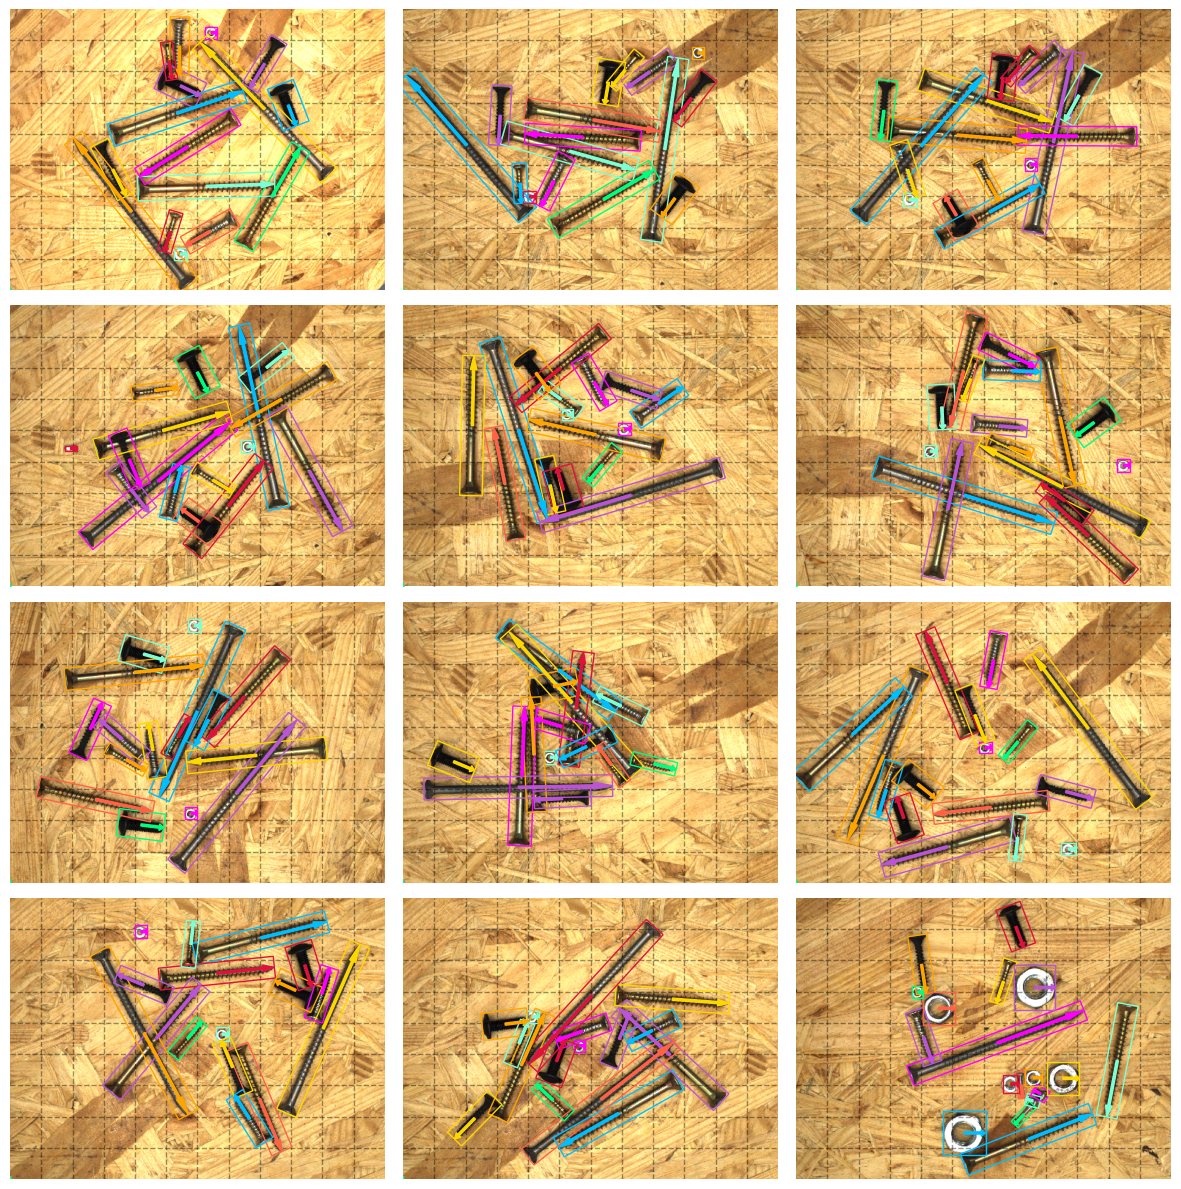

In [119]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(4, 3, figsize=(12, 12))
axs = np.concatenate([ax1, ax2, ax3, ax4], axis=-1)
for img, ax in enumerate(axs):
    lines = []
    for i in range(1, 12, 1):
        line = i * 512/12
        lines.append([(line, 0), (line, 384)])
    for i in range(1, 9, 1):
        line = i * 384/9
        lines.append([(0, line), (512, line)])
    grid_lines = mpl.collections.LineCollection(lines, colors='black', lw=1, ls='--', alpha=.4)
    ax.set(
            ylim=[0, 384],
            xlim=[0, 512],
            xticks=list(range(0, 512,int(np.ceil(512/12)))),
            yticks=list(range(0, 384, int(np.ceil(384/9)))),
            )
    ax.axis('off')
    ax.imshow(load_img(images[img], target_size=(384, 512)))
    ax.add_collection(grid_lines)
    for idx, box in enumerate(label_corners[img]):
        n_color = next(color)
        bbox, arrow = display_label(labels[img, idx, 14:], color=n_color)
        ax.add_patch(bbox)
        ax.add_patch(arrow)
        # ax.add_patch(Polygon(box, fill=None, edgecolor="tomato", lw=5))
fig.tight_layout()
plt.savefig("./images/bounding_box_examples_16.png")
plt.show()